In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from OnlineLODA import OnlineLODA
from sklearn.metrics import roc_auc_score

In [2]:
np.random.seed(42)

In [3]:
datasets = ['cover.csv', 'creditcardfraud_normalised.csv', 'musk.csv', 'http.csv', 'smtp.csv', 'mammography.csv']

In [4]:
datasets

['cover.csv',
 'creditcardfraud_normalised.csv',
 'musk.csv',
 'http.csv',
 'smtp.csv',
 'mammography.csv']

In [8]:
def loader(i):
    df = pd.read_csv(f'../datasets/{i}', header=None)
    batch_size = max(200, round(df.shape[0]//200, -2))
    data = df[df.columns[:-1]].values
    label = df[df.columns[-1]].values
    return data, label, batch_size

In [9]:
for d in datasets:
    data, label, bs = loader(d)
    print(f'{d}\t{label.shape[0]}\t{np.sum(label==1)}\t{np.sum(label==0)}')

cover.csv	286048	2747	283301
creditcardfraud_normalised.csv	284807	492	284315
musk.csv	3062	97	2965
http.csv	567498	2211	565287
smtp.csv	95156	30	95126
mammography.csv	11183	260	10923


In [10]:
import matplotlib.dates as mdates


def anosc_plot(preds, label, filename = None):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    #print(preds.shape)
    ax.scatter(np.arange(preds.shape[0])[label==0], preds[label==0], color="blue", s=0.2, rasterized=True)
    ax.scatter(np.arange(preds.shape[0])[label==1], preds[label==1], color="red", s=0.2, rasterized=True)
    
    # ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%j'))
    ax.legend(['Normal', 'Anomaly'])
    
    # ax.vlines(mixed_dates, 0,35, linewidth=0.2, color="black")
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename, dpi=300)
    #plt.show()

In [11]:
def do_data_set(dataset, histperbatch):
    x,label,bs = loader(dataset)
    b_results = pd.DataFrame(columns=np.arange(20))
    b_aucs = []

    for i in np.arange(20):
        print(f"           of round {i+1}, {dataset}", end='\r')
        b = OnlineLODA(dimension = x.shape[1], X=x, hist_per_batch=histperbatch, batch_size=bs)
        b_preds = np.hstack(b.predictions)
        b_results[i] = b_preds
        b_aucs.append(roc_auc_score(y_true=label, y_score=b_preds))
        
    anosc_plot(b_results.mean(axis=1), label, None)
    return np.mean(b_aucs), np.std(b_aucs), bs

In [12]:
results = []

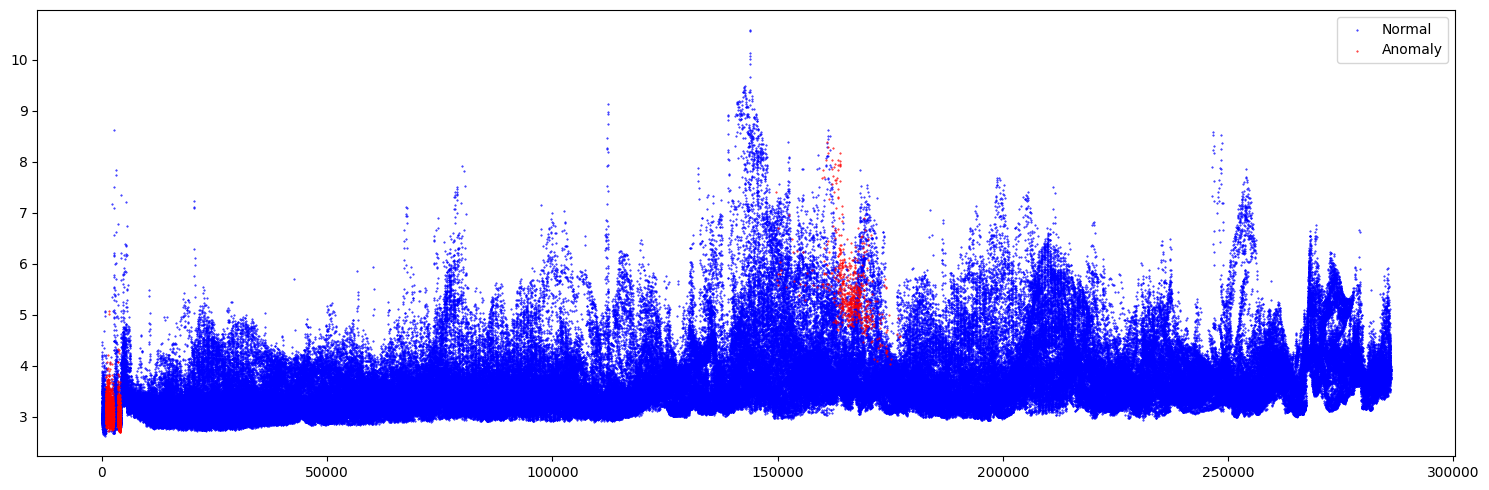

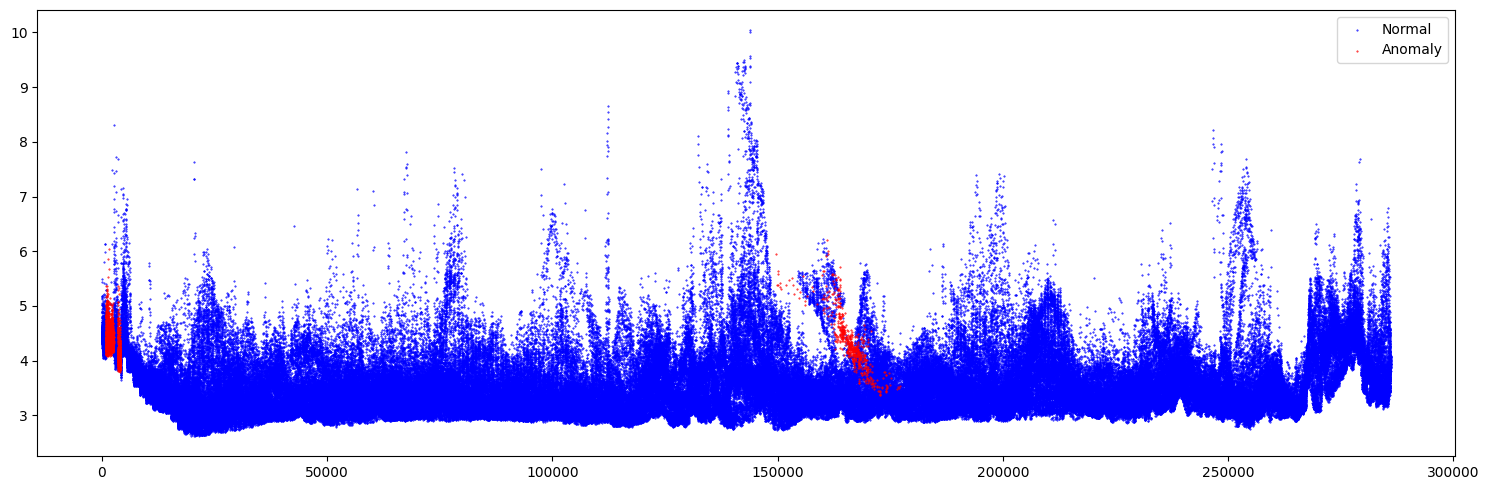

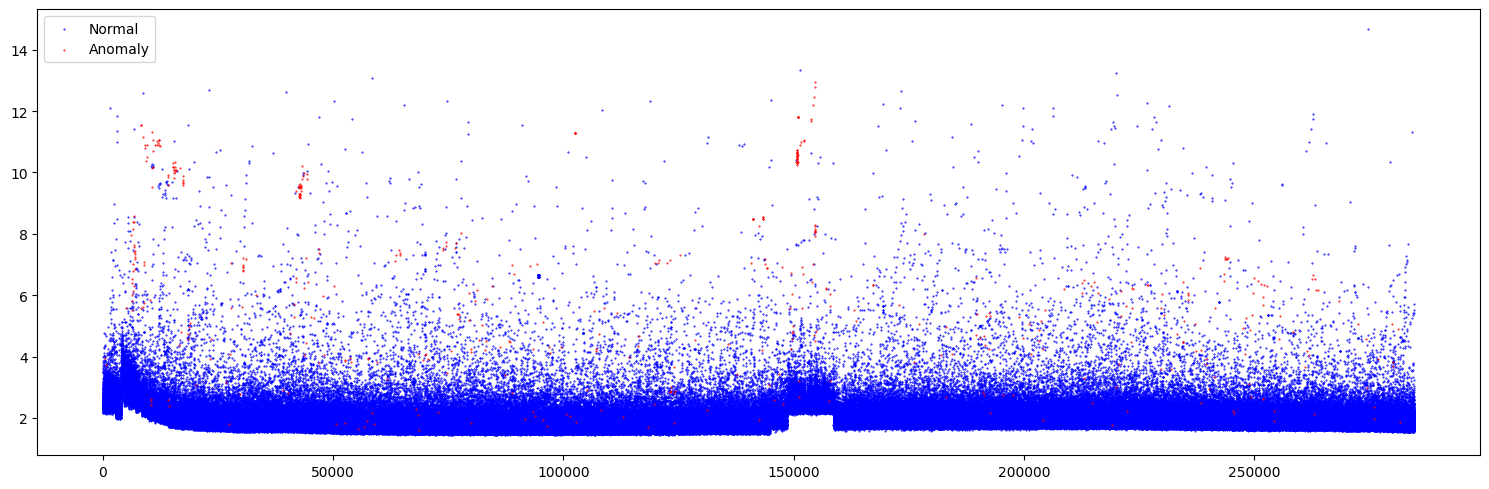

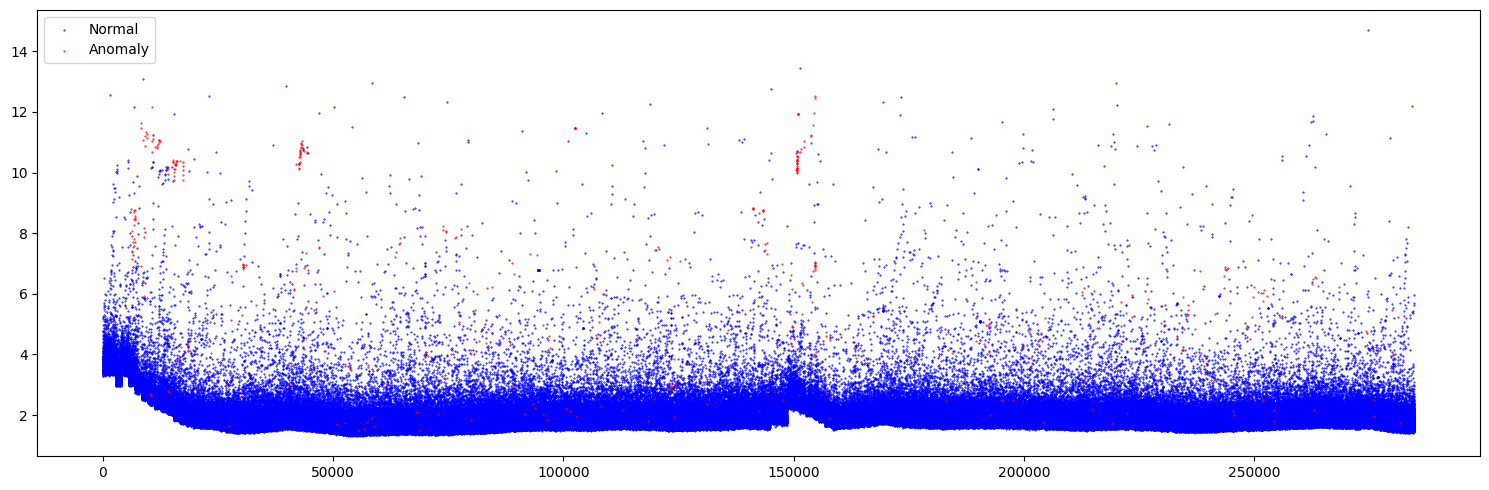

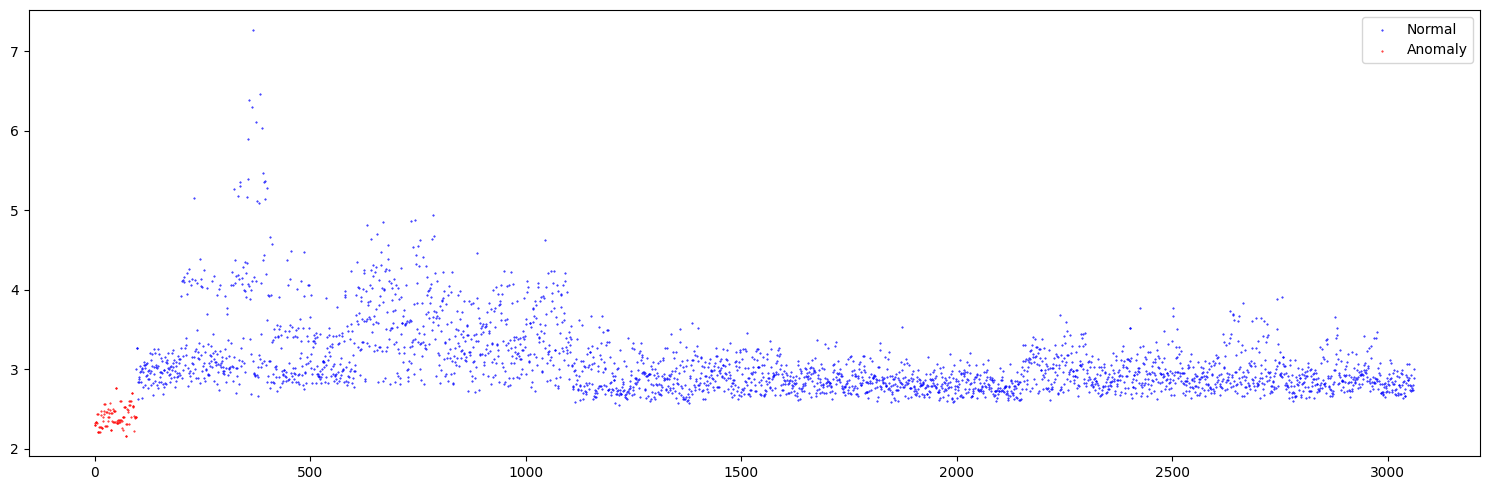

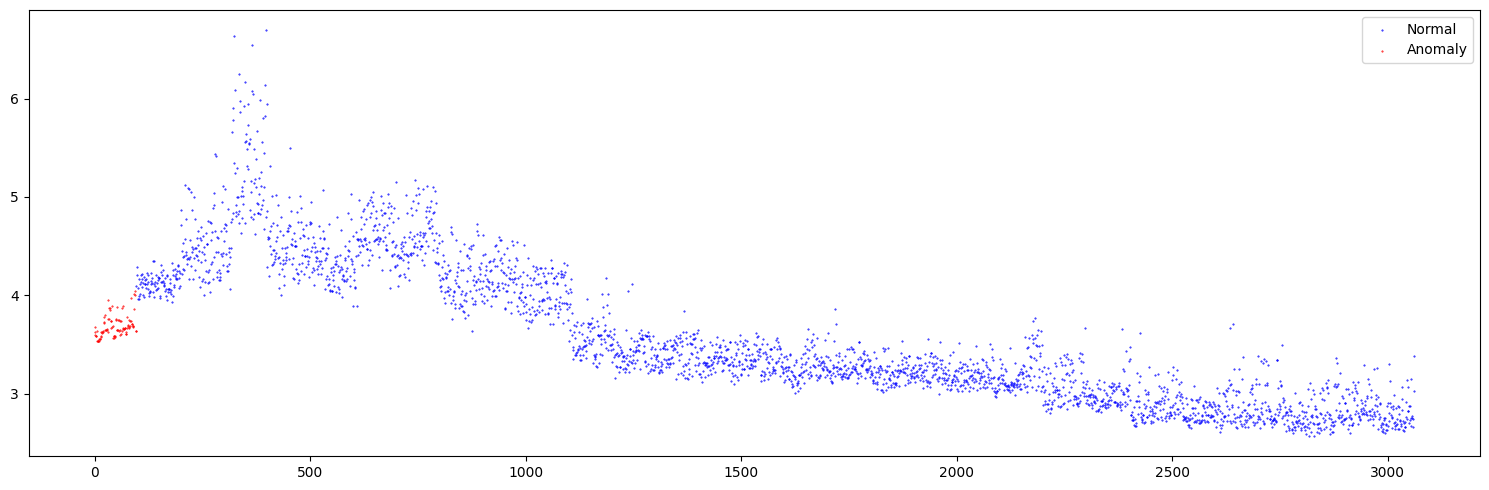

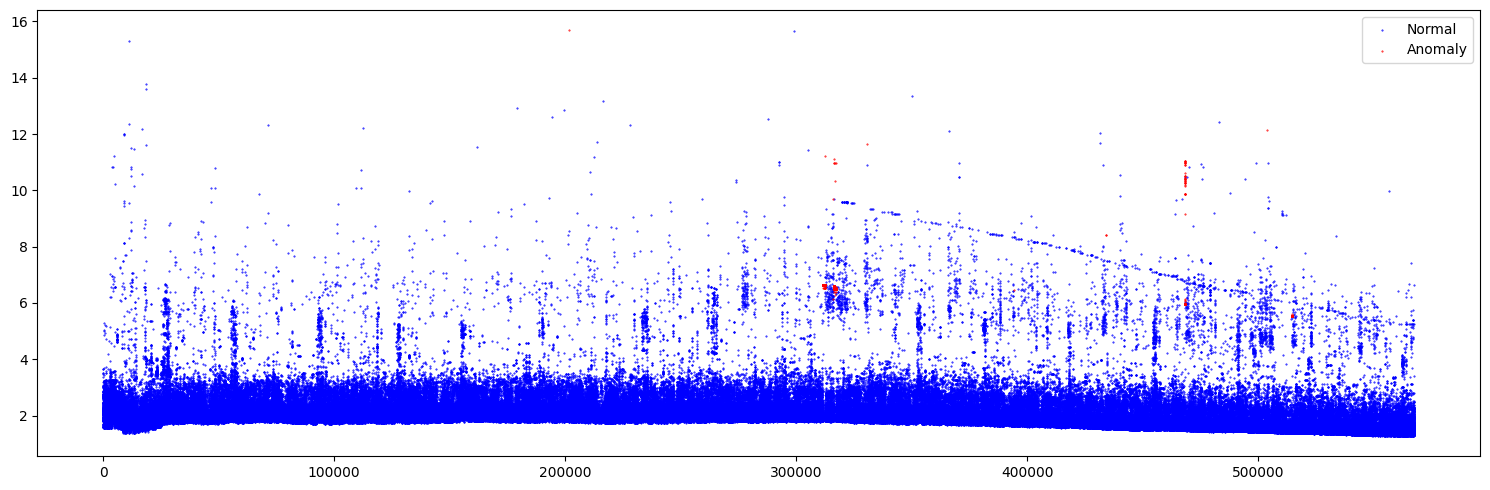

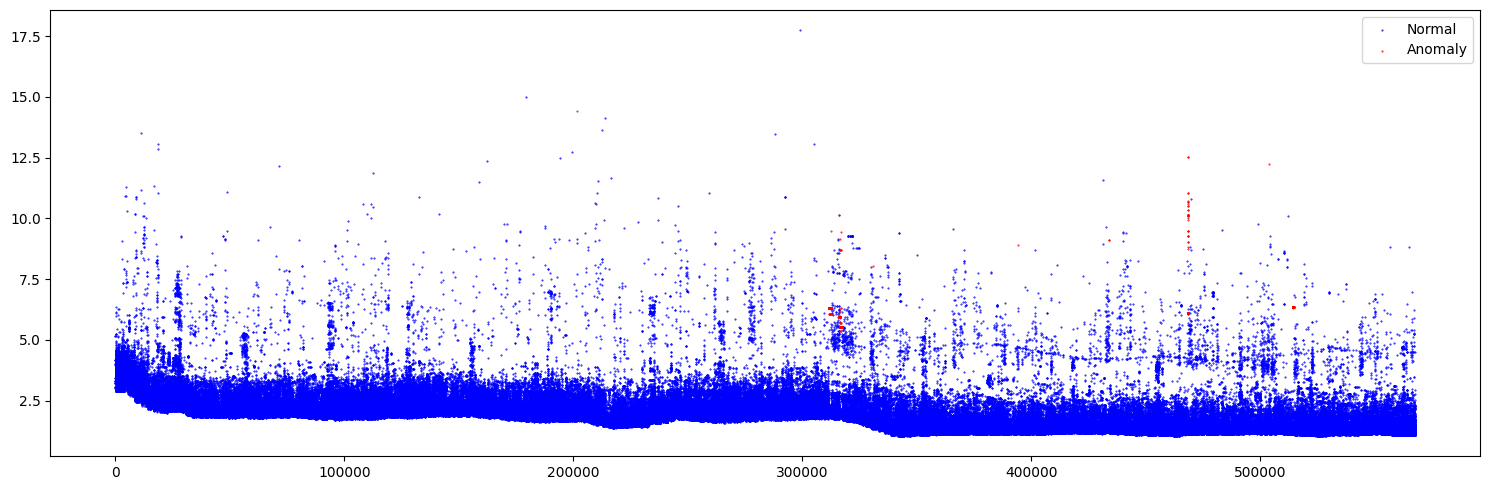

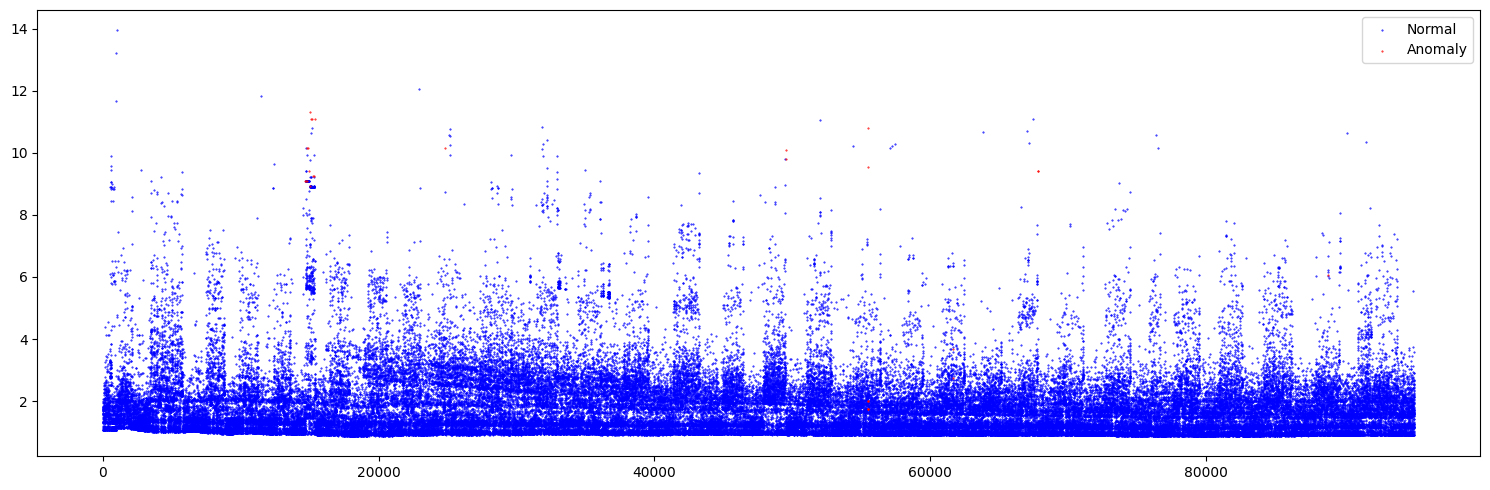

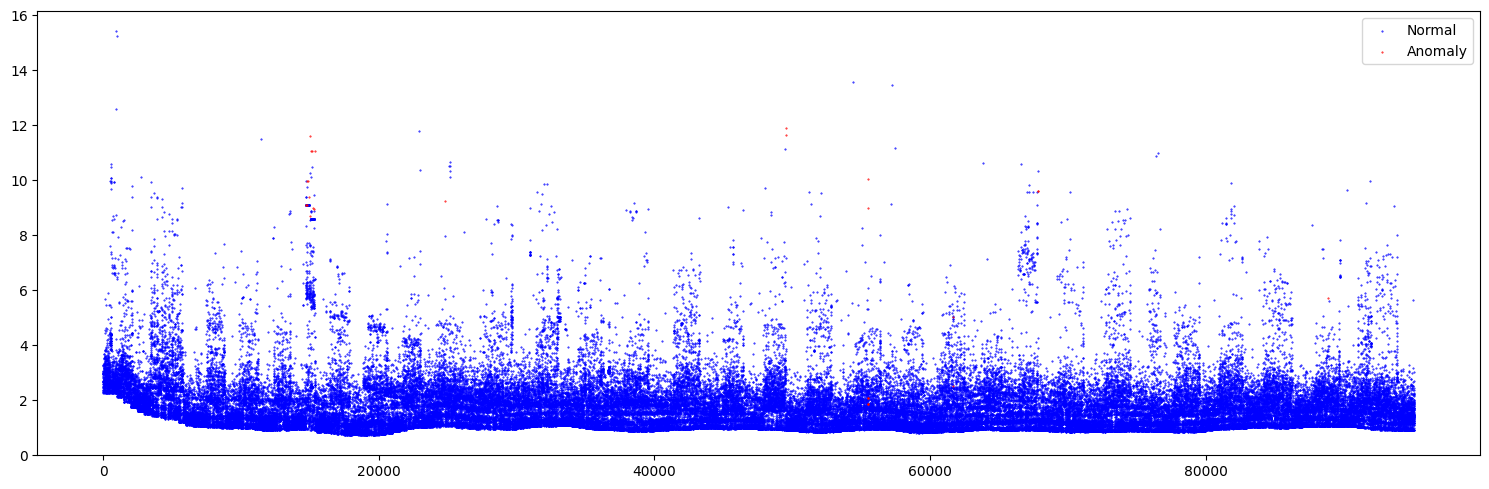

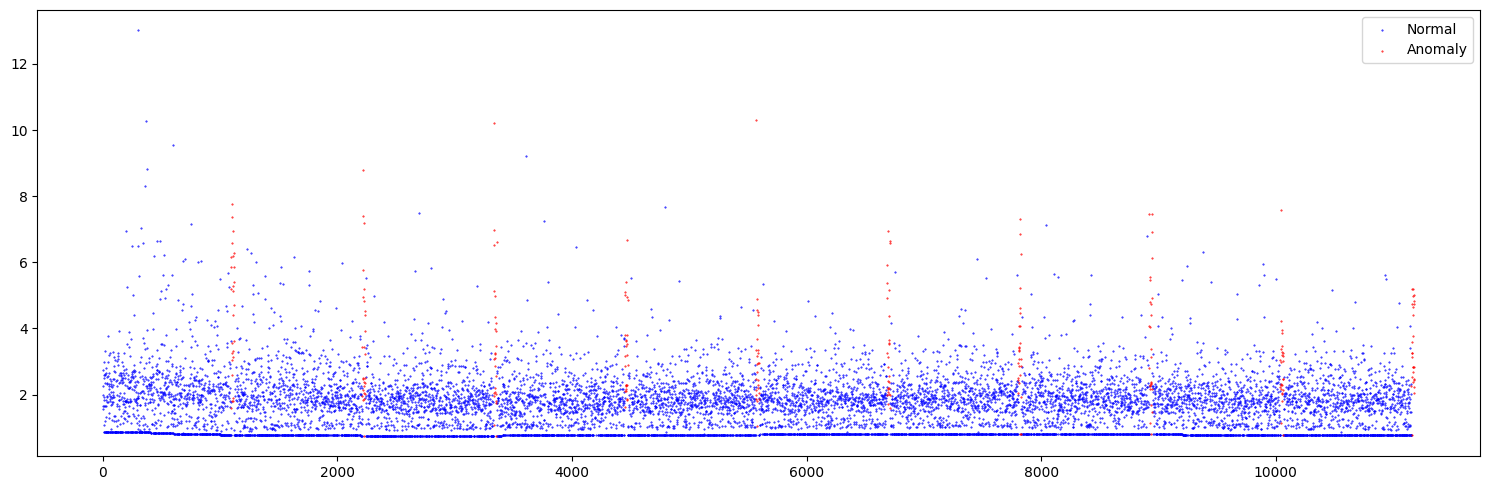

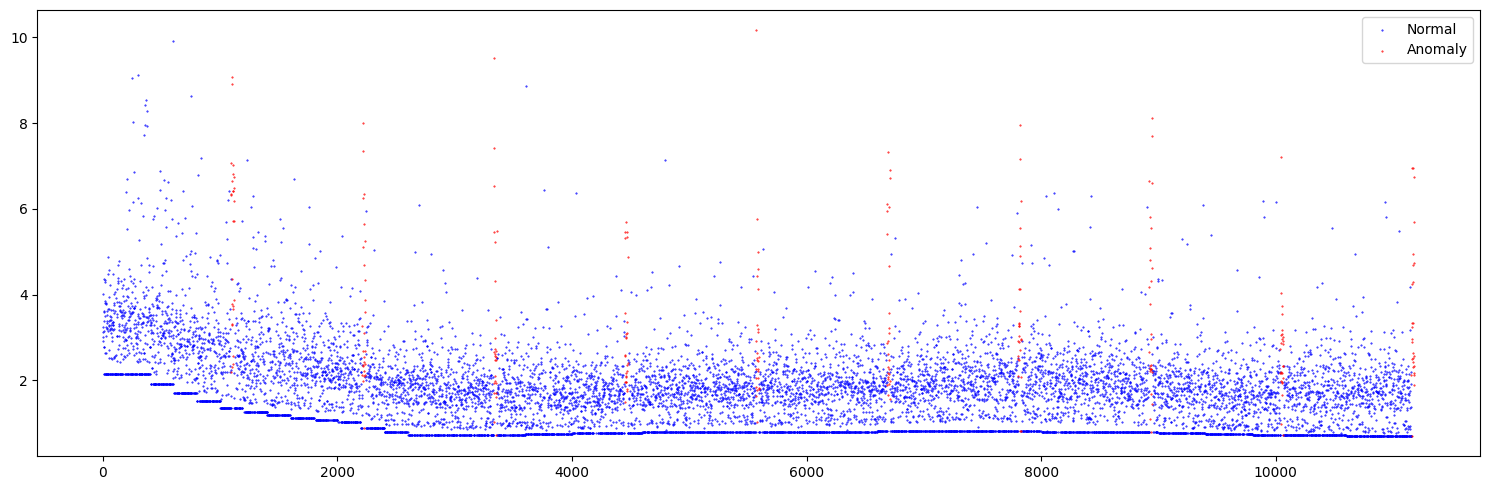

In [13]:
for d in datasets:
    aucm, aucs, bs = do_data_set(d, 1)
    results.append({'dataset':d, 'mean':aucm, 'std': aucs, 'bs':bs, 'hpb':1})
    
    aucm, aucs, bs = do_data_set(d, 10)
    results.append({'dataset':d, 'mean':aucm, 'std': aucs, 'bs':bs, 'hpb':10})

In [14]:
results

[{'dataset': 'cover.csv',
  'mean': 0.39149408373715,
  'std': 0.07664035852757925,
  'bs': 1400,
  'hpb': 1},
 {'dataset': 'cover.csv',
  'mean': 0.8903370105824548,
  'std': 0.01428666032507657,
  'bs': 1400,
  'hpb': 10},
 {'dataset': 'creditcardfraud_normalised.csv',
  'mean': 0.9459321164376109,
  'std': 0.0037081385562488045,
  'bs': 1400,
  'hpb': 1},
 {'dataset': 'creditcardfraud_normalised.csv',
  'mean': 0.9465688813606915,
  'std': 0.0016741830361853692,
  'bs': 1400,
  'hpb': 10},
 {'dataset': 'musk.csv',
  'mean': 0.21272656942681803,
  'std': 0.09289031005697336,
  'bs': 200,
  'hpb': 1},
 {'dataset': 'musk.csv',
  'mean': 0.6453613462909199,
  'std': 0.053029916423004156,
  'bs': 200,
  'hpb': 10},
 {'dataset': 'http.csv',
  'mean': 0.9964416714995084,
  'std': 0.0020007871974955303,
  'bs': 2800,
  'hpb': 1},
 {'dataset': 'http.csv',
  'mean': 0.9963484487197366,
  'std': 0.0016008055083201024,
  'bs': 2800,
  'hpb': 10},
 {'dataset': 'smtp.csv',
  'mean': 0.90782665447

In [15]:
pd.DataFrame.from_dict(results)

,dataset,mean,std,bs,hpb
0,cover.csv,0.391494,0.076640,1400,1
1,cover.csv,0.890337,0.014287,1400,10
2,creditcardfraud_normalised.csv,0.945932,0.003708,1400,1
3,creditcardfraud_normalised.csv,0.946569,0.001674,1400,10
4,musk.csv,0.212727,0.092890,200,1
5,musk.csv,0.645361,0.053030,200,10
6,http.csv,0.996442,0.002001,2800,1
7,http.csv,0.996348,0.001601,2800,10
8,smtp.csv,0.907827,0.009471,500,1
9,smtp.csv,0.920477,0.007638,500,10


# Repeated experiment with shuffled data

In [22]:
def loader_shuffle(i):
    df = pd.read_csv(f'../datasets/{i}', header=None)
    shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    batch_size = max(200, round(shuffled_df.shape[0]//200, -2))
    data = shuffled_df[shuffled_df.columns[:-1]].values
    label = shuffled_df[shuffled_df.columns[-1]].values
    return data, label, batch_size

In [23]:
def do_data_set_shuffle(dataset, histperbatch):
    x,label,bs = loader_shuffle(dataset)
    b_results = pd.DataFrame(columns=np.arange(20))
    b_aucs = []

    for i in np.arange(20):
        print(f"           of round {i+1}, {dataset}", end='\r')
        b = OnlineLODA(dimension = x.shape[1], X=x, hist_per_batch=histperbatch, batch_size=bs)
        b_preds = np.hstack(b.predictions)
        b_results[i] = b_preds
        b_aucs.append(roc_auc_score(y_true=label, y_score=b_preds))
        
    anosc_plot(b_results.mean(axis=1), label, None)
    return np.mean(b_aucs), np.std(b_aucs), bs

In [24]:
results_shuffle = []

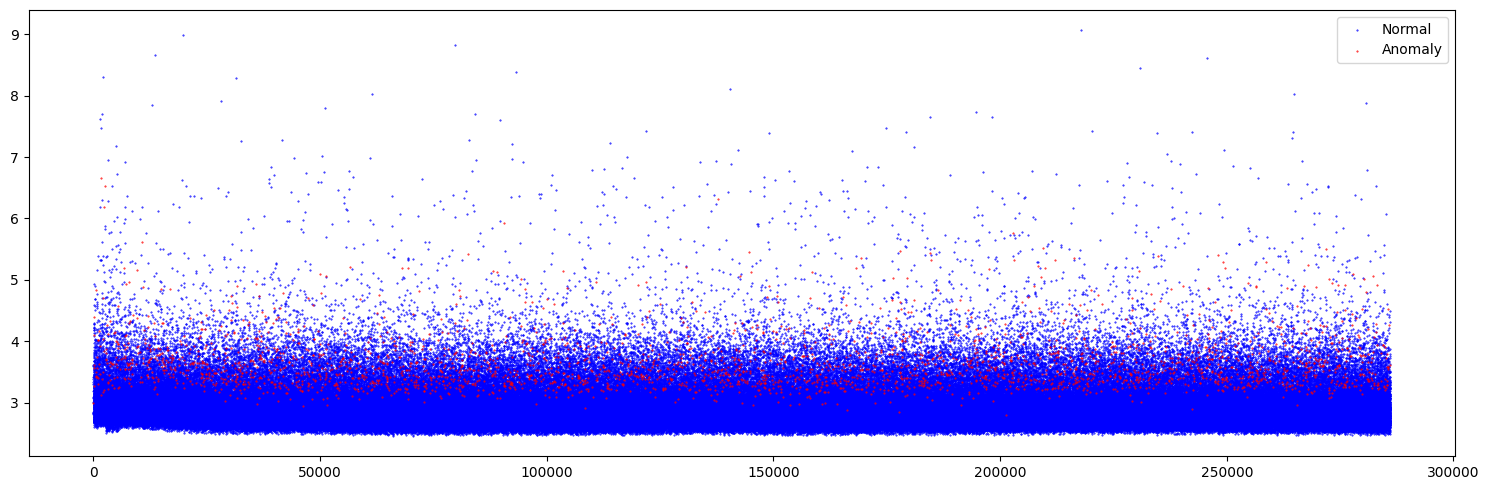

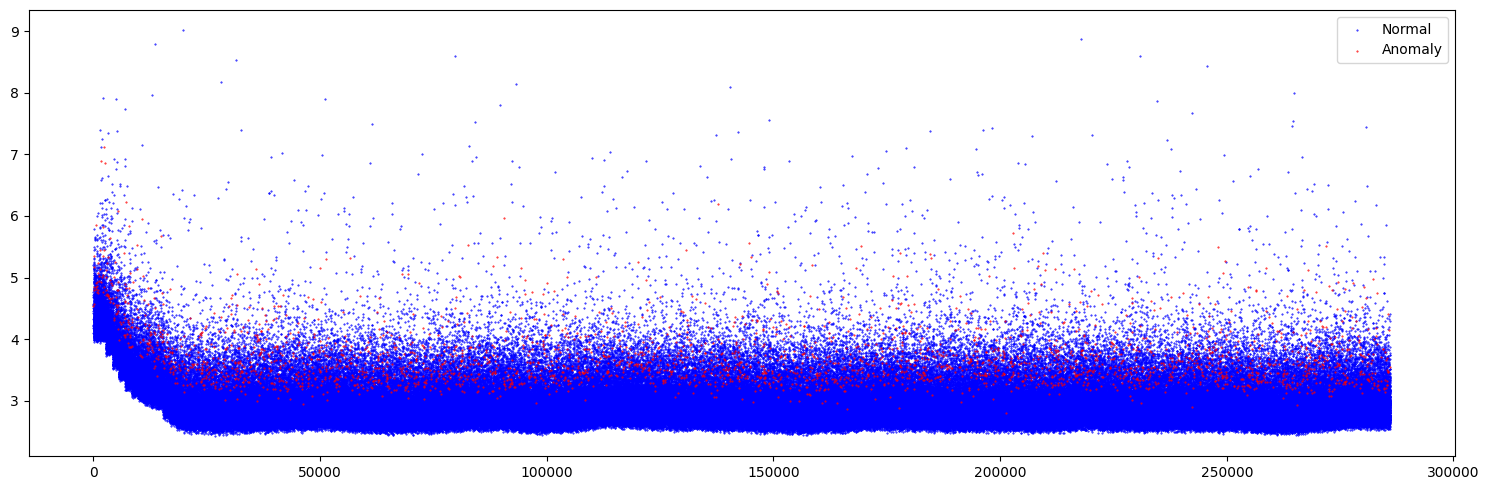

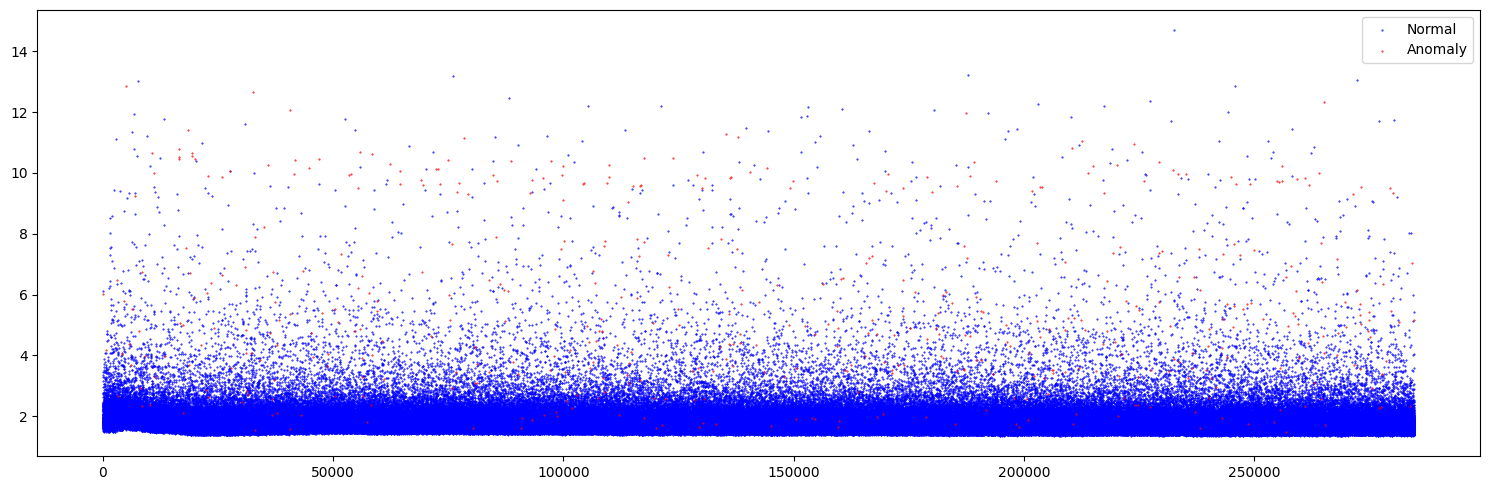

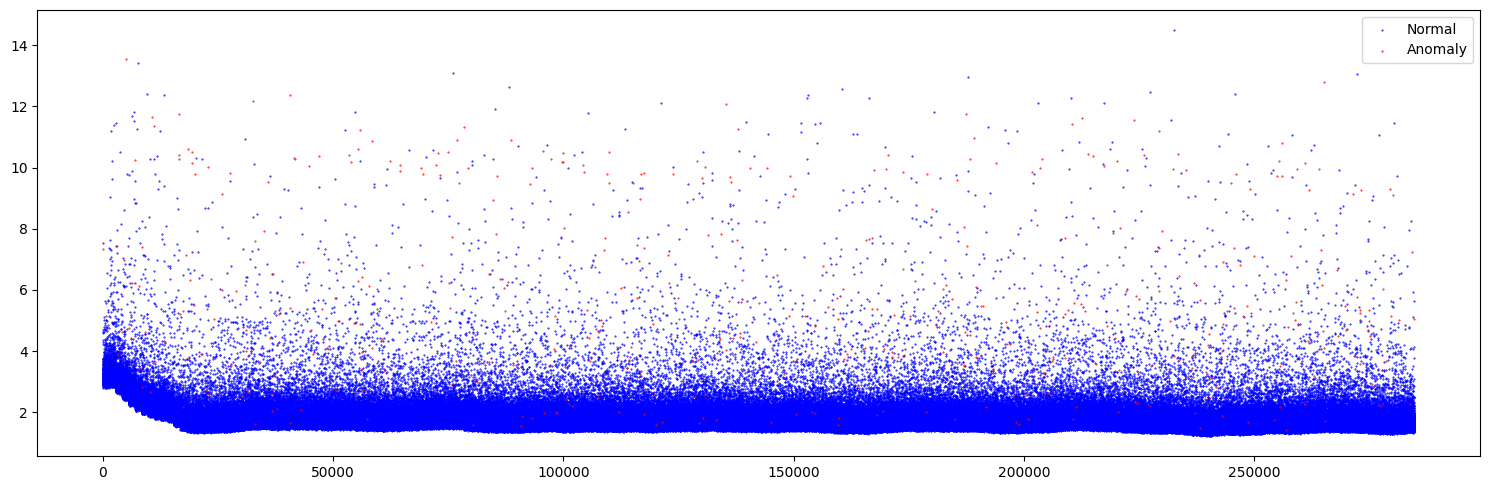

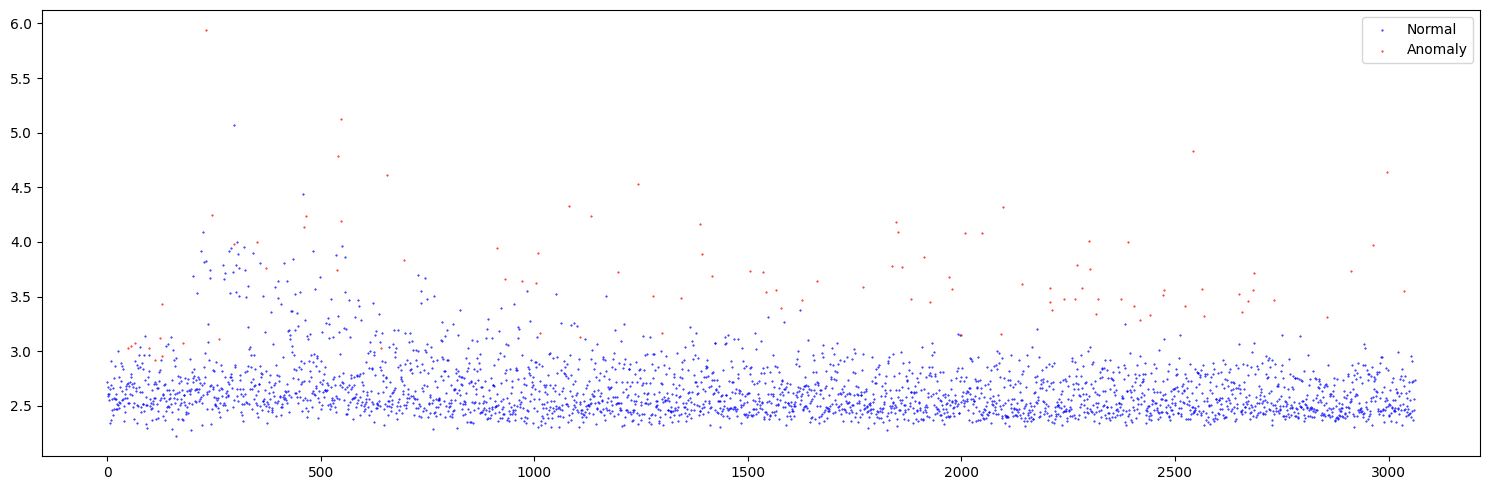

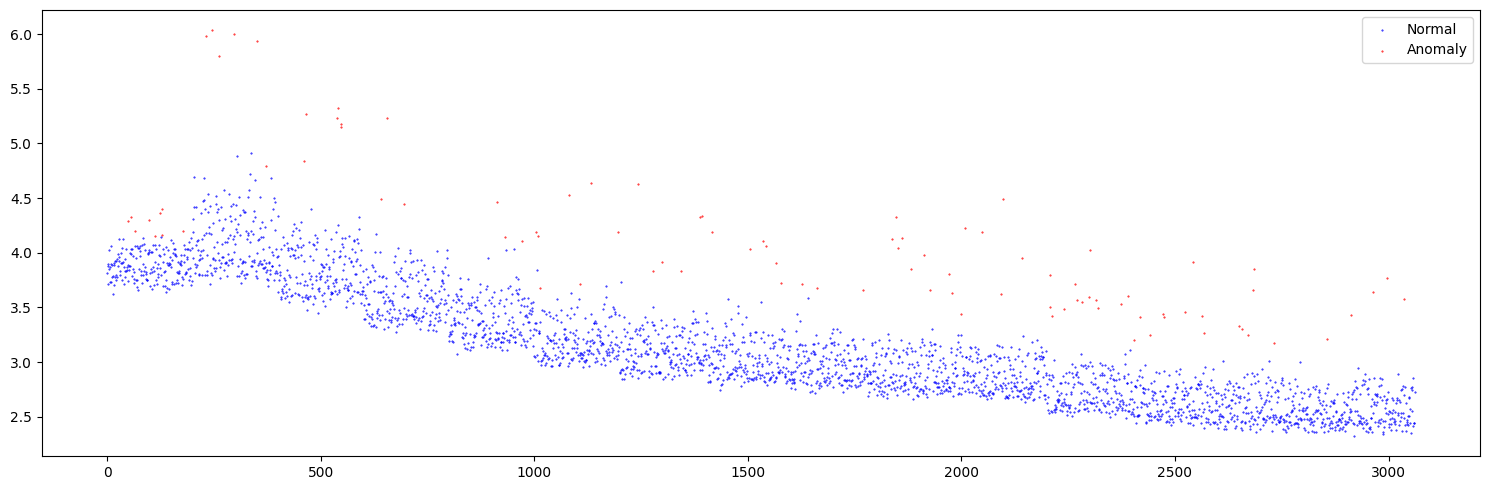

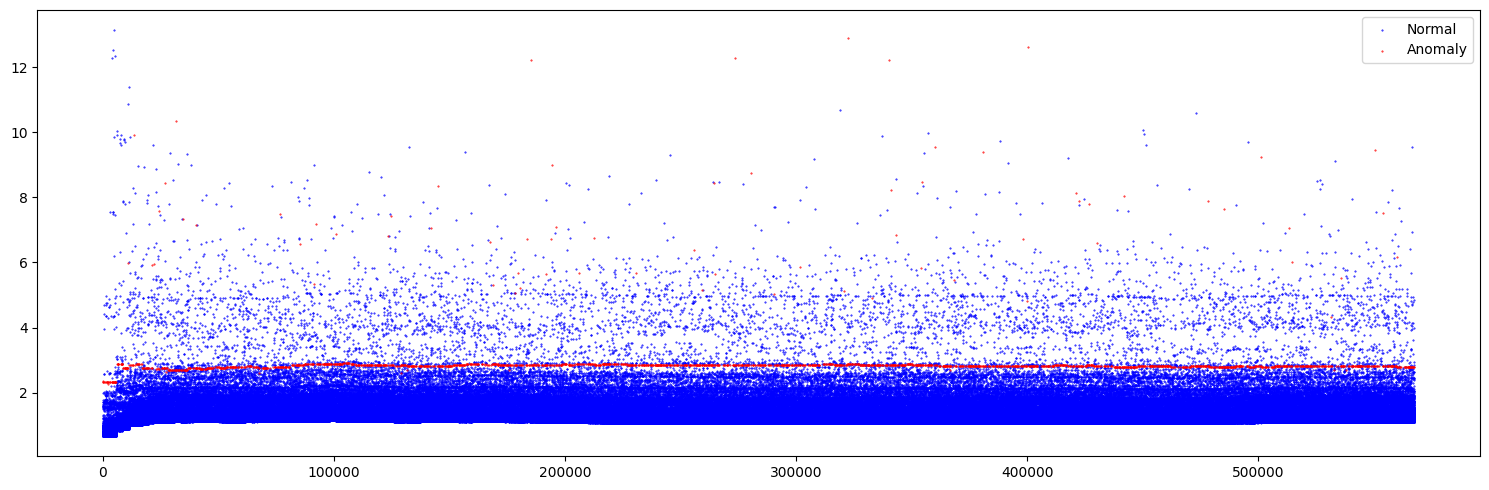

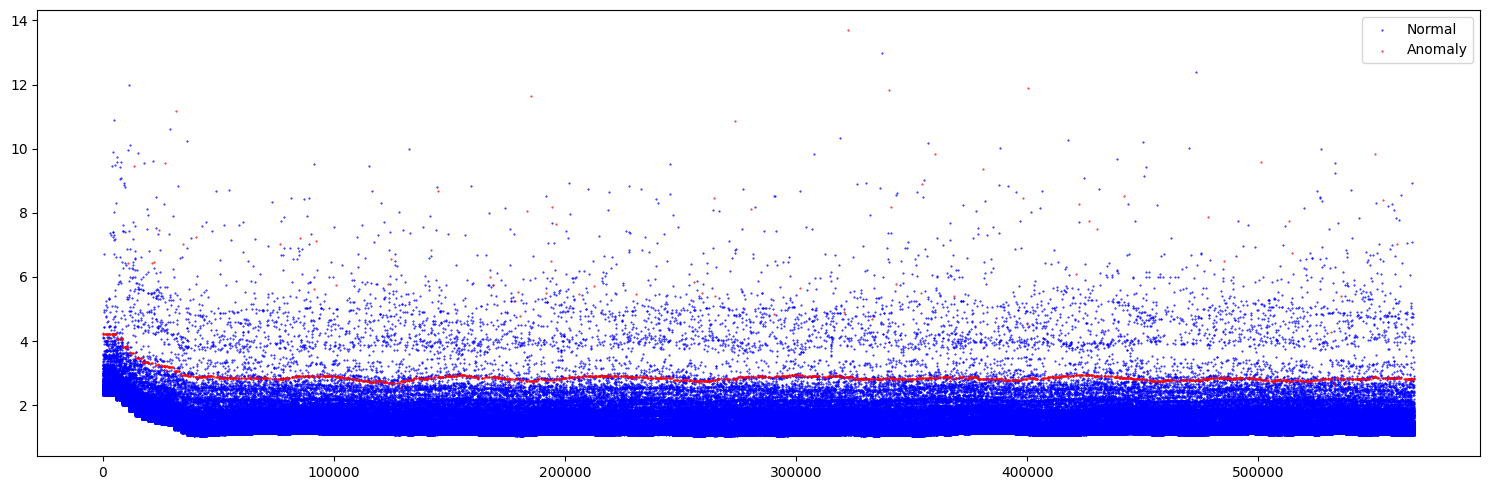

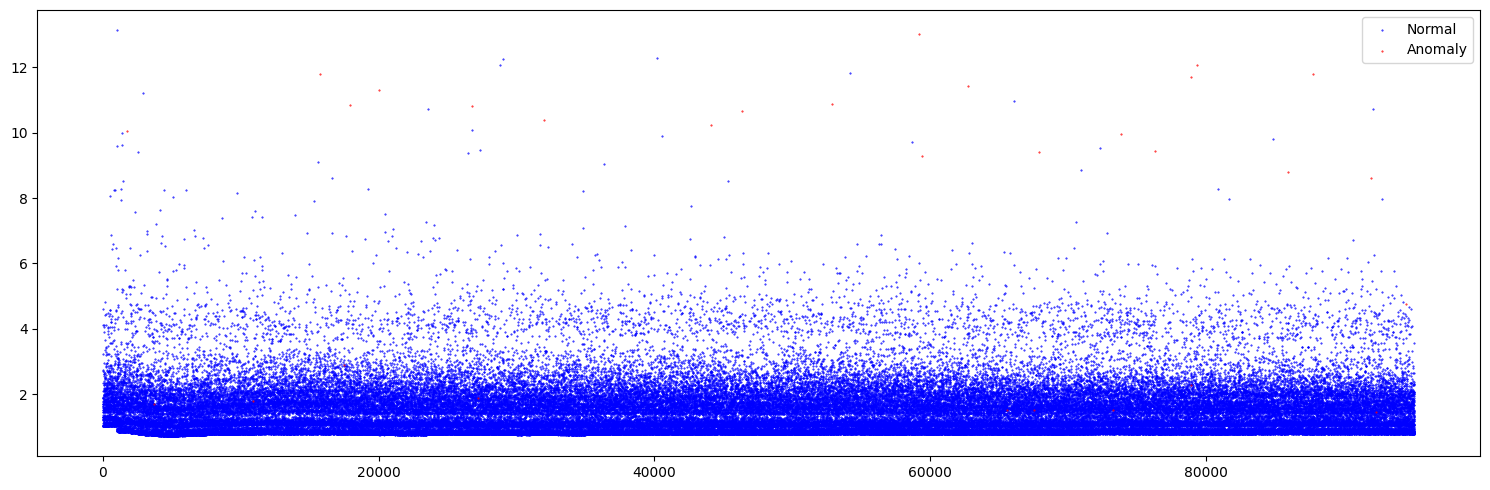

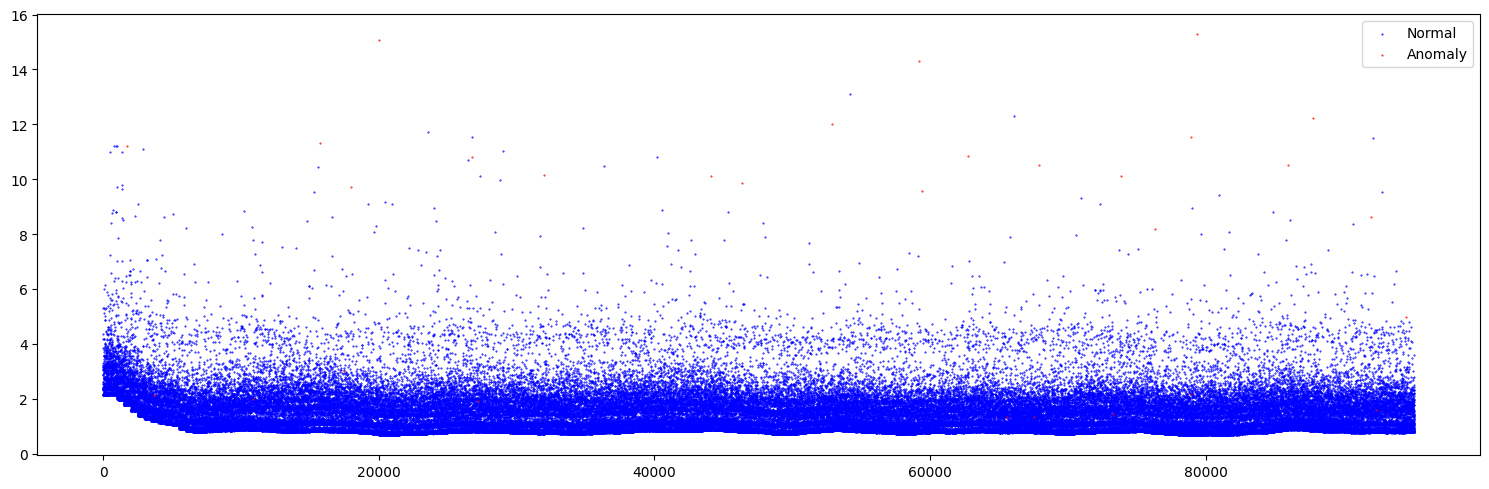

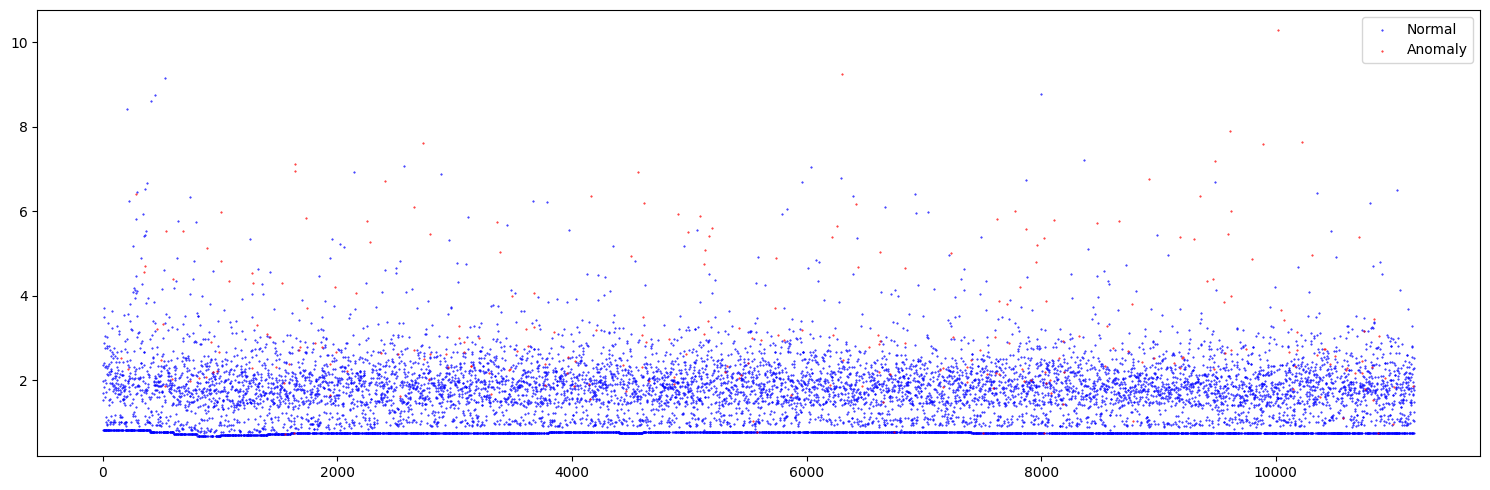

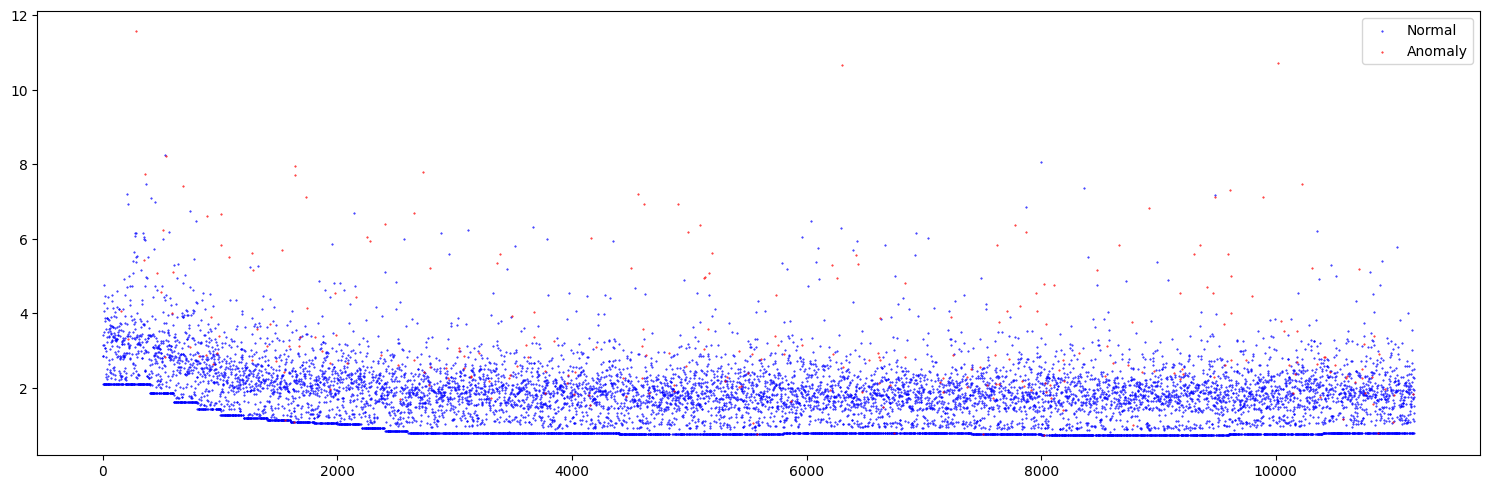

In [25]:
for d in datasets:
    aucm, aucs, bs = do_data_set_shuffle(d, 1)
    results_shuffle.append({'dataset':d, 'mean':aucm, 'std': aucs, 'bs':bs, 'hpb':1})
    
    aucm, aucs, bs = do_data_set_shuffle(d, 10)
    results_shuffle.append({'dataset':d, 'mean':aucm, 'std': aucs, 'bs':bs, 'hpb':10})

In [26]:
pd.DataFrame.from_dict(results_shuffle).to_csv('datasets_test_shuffle.csv')

In [27]:
pd.DataFrame.from_dict(results_shuffle)

,dataset,mean,std,bs,hpb
0,cover.csv,0.892633,0.024145,1400,1
1,cover.csv,0.893869,0.006172,1400,10
2,creditcardfraud_normalised.csv,0.948603,0.003821,1400,1
3,creditcardfraud_normalised.csv,0.947523,0.001373,1400,10
4,musk.csv,0.858329,0.073793,200,1
5,musk.csv,0.863311,0.023338,200,10
6,http.csv,0.975770,0.012567,2800,1
7,http.csv,0.983678,0.003276,2800,10
8,smtp.csv,0.910559,0.007887,500,1
9,smtp.csv,0.911011,0.003473,500,10
